In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('autos.csv')
df_copy = df.copy()

In [3]:
df_copy.dropna(inplace=True)

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Признаки   
   
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

#### Целевой признак    
      
- Price — цена (евро)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


> Датасет содержит 16 признаков, описывающих характеристики 354 369 автомобилей. Тип данный: int и object. Чтобы работать с данными лучше сделать следущие шаги:   
1. Перевести признаки DateCrawled, DateCreated в формат даты;
2. Проверить пропуски и дубликаты и избавиться от них;
3. Проверить наличие выбросов и придумать стратегию для них;
4. Удалить ненужные признаки: PostalCode, NumberOfPictures, LastSeen, RegistrationMonth;
5. Удалить нереалистичные года в столбце RegistrationYear
6. Удалить автомобили стоимостью 0 евро

In [7]:
print('Дубликатов:', df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)

Дубликатов: 4


In [8]:
# обработка пропусков
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

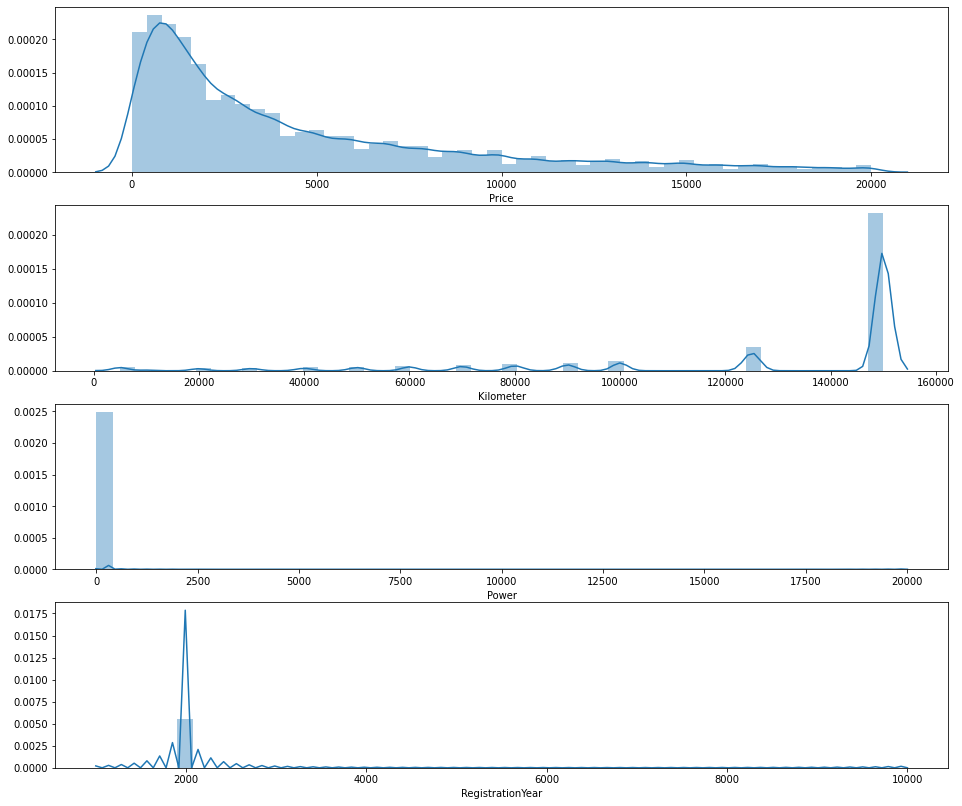

In [9]:
numerical = ['Price', 'Kilometer', 'Power', 'RegistrationYear']
fig, ax = plt.subplots(4,1, figsize=(16, 14))
for variable, subplot in zip(numerical, ax):
    sns.distplot(df[variable], ax=subplot)

> По графику мощности видно, что пропуски заполнены нулями, их лучше заполнить более оптимальными значениями, например, найти те же самые модели и заполнить пропуски показателями мощности найденных моделей. Также много нулей среди цен на автомобили, эти данные будут мешать обучению и их лучше удалить. Тогда распределение показателей будет больше похоже на нормальное, будет меньше выбросов и аномалий и модели будет проще искать зависимость.

### Заполнение пропусков

Для начала избавимся от выбросов по году и мощности, а также удалим экземпляры с ценой 0 евро.

In [10]:
df = df[(df.RegistrationYear > 1990) & (df.RegistrationYear < 2021)]
df = df[df.Power < 500]
df = df[df.Price > 0]

Предположим, что если продавец не указал, восстановлена машина или нет, то она не восстановлена:

In [11]:
df.NotRepaired.fillna('yes', inplace=True)

In [12]:
df.Power = df.Power.replace(0, np.nan)
power_year = df.groupby("RegistrationYear")['Power'].agg(lambda x:x.value_counts().index[0]).to_dict()

In [13]:
def filler_power(row):
    year = row['RegistrationYear']
    power = row['Power']
    if np.isnan(power):
        return power_year[year]
    else:
        return power

In [14]:
df.Power = df[['RegistrationYear', 'Power']].apply(filler_power, axis=1)

In [15]:
gearbox_brands = df.groupby("Brand")['Gearbox'].agg(lambda x:x.value_counts().index[0]).to_dict()
df.Gearbox.fillna(np.nan, inplace=True)
def filler_gear(row):
    brand = row['Brand']
    gear = row['Gearbox']
    if gear is np.nan:
        return gearbox_brands[brand]
    else:
        return gear
df.Gearbox = df[['Gearbox', 'Brand']].apply(filler_gear, axis=1)

In [16]:
models_vehType = df_copy.groupby("Model")['VehicleType'].agg(lambda x:x.value_counts().index[0]).to_dict()

df['Model'].fillna('NG', inplace=True)
def filler_veh_type(row):
    model = row['Model']
    veh_type = row['VehicleType']
    if veh_type == 'NG' and model != 'NG':
        return models_vehType[model]
    elif veh_type != 'NG':
        return veh_type
    elif veh_type == 'NG' and model == 'NG':
        return None

In [17]:
df.VehicleType = df[['VehicleType', 'Model']].apply(filler_veh_type, axis=1)

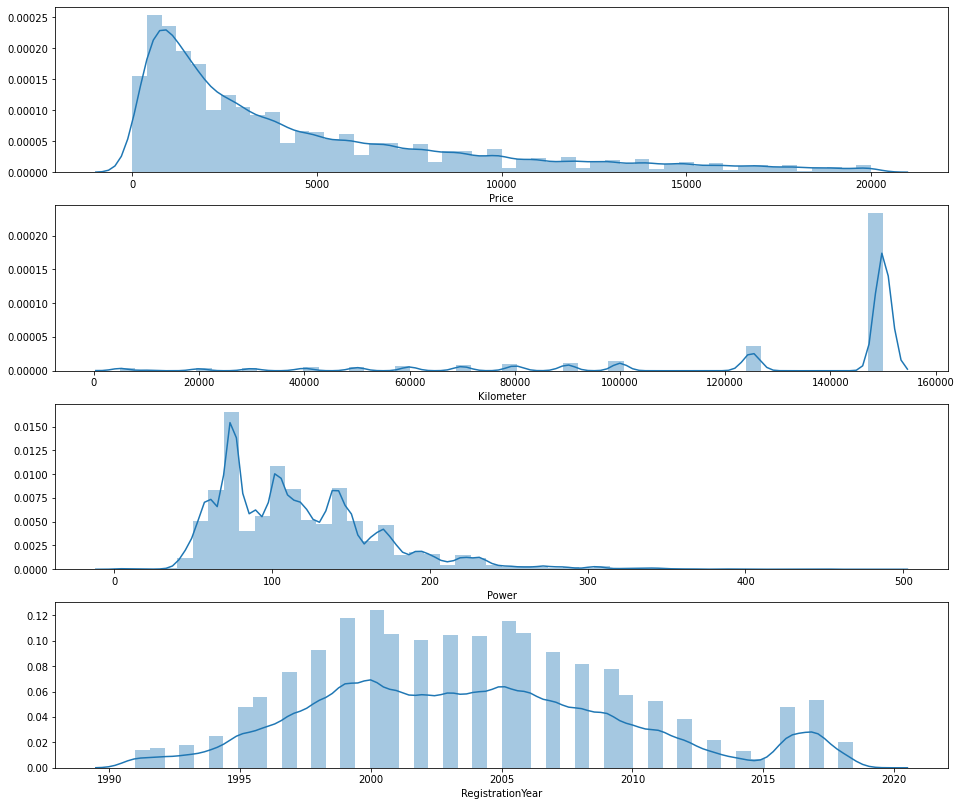

In [18]:
numerical = ['Price', 'Kilometer', 'Power', 'RegistrationYear']
fig, ax = plt.subplots(4,1, figsize=(16, 14))
for variable, subplot in zip(numerical, ax):
    sns.distplot(df[variable], ax=subplot)

#### Удаление ненужных признаков

При первом прогоне Catboost веса признаков определились следующим образом:   
   
- VehicleType : 5.0
- RegistrationYear : 39.0
- Gearbox : 0.0
- Power : 30.0
- Model : 4.0
- Kilometer : 8.0
- FuelType : 2.0
- Brand : 9.0
- NotRepaired : 3.0
- Year : 0.0
- Month : 0.0
- Day : 0.0

Можно сделать вывод, что дата не важна совсем - её можно удалить. Параметр FuelType имеет слабый вес, поэтому лучше удалить столбец, чем удалять 30000 строк из-за пропусов по этому признаку. Коробка передач также не важна, поэтому этот столбец тоже можно удалить.

In [19]:
df.drop(['PostalCode', 'NumberOfPictures', 'LastSeen', 'RegistrationMonth', 'DateCreated', 'DateCrawled', 'FuelType'], axis=1, inplace=True)

In [20]:
print('Пропусков:', df.isna().sum().sum())

Пропусков: 32172


In [21]:
df.dropna(inplace=True)

In [22]:
print('Пропусков:', df.isna().sum().sum())
print('Дубликатов:', df.duplicated().sum())
print('Осталось строк:', df.shape[0])

Пропусков: 0
Дубликатов: 47320
Осталось строк: 299516


### CatBoost

#### Кодирование признаков

In [23]:
df.Model = df.Model.replace('other', 'other_model')
categorial = df.select_dtypes('object').columns.to_list()

for col in categorial:
    dum = pd.get_dummies(df[col], drop_first=True)
    df = pd.concat([df, dum], axis=1)
    df.drop(col, axis=1, inplace=True)

In [24]:
features = df.drop(['Price'], axis=1)
target = df['Price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=1)

In [25]:
categorial = df.select_dtypes(include='object').columns.to_list() 

In [26]:
best_rmse = 10000
best_model = None
learning_rate = map(lambda x: x/10, range(1, 10))
for lr in learning_rate:
    print('learning_rate:', lr)
    model = CatBoostRegressor(iterations=150, cat_features=categorial, verbose=50, learning_rate=lr)
    model.fit(features_train, target_train)
    preds = model.predict(features_test)
    rmse = (mean_squared_error(target_test, preds)) ** .5
    if rmse < best_rmse:
        best_model = model

learning_rate: 0.1
0:	learn: 4258.7844939	total: 169ms	remaining: 25.1s
50:	learn: 1822.3467092	total: 5.85s	remaining: 11.4s
100:	learn: 1721.0899261	total: 11.6s	remaining: 5.6s
149:	learn: 1673.4554317	total: 18.5s	remaining: 0us
learning_rate: 0.2
0:	learn: 3949.3236342	total: 85ms	remaining: 12.7s
50:	learn: 1722.9270051	total: 4.81s	remaining: 9.34s
100:	learn: 1642.6892990	total: 11.1s	remaining: 5.4s
149:	learn: 1599.0752142	total: 15s	remaining: 0us
learning_rate: 0.3
0:	learn: 3654.5463009	total: 122ms	remaining: 18.1s
50:	learn: 1674.1150550	total: 4.09s	remaining: 7.94s
100:	learn: 1596.4472709	total: 8.1s	remaining: 3.93s
149:	learn: 1556.8182219	total: 11.9s	remaining: 0us
learning_rate: 0.4
0:	learn: 3378.2984366	total: 101ms	remaining: 15.1s
50:	learn: 1650.4182123	total: 5.98s	remaining: 11.6s
100:	learn: 1576.1417230	total: 10.2s	remaining: 4.95s
149:	learn: 1535.8436640	total: 13.9s	remaining: 0us
learning_rate: 0.5
0:	learn: 3125.4970478	total: 81.3ms	remaining: 12.

In [64]:
%%time
model = CatBoostRegressor(iterations=150, cat_features=categorial, verbose=50, learning_rate=0.9)
model.fit(features_train, target_train)

0:	learn: 2485.6499641	total: 99.3ms	remaining: 14.8s
50:	learn: 1603.7544793	total: 6.27s	remaining: 12.2s
100:	learn: 1527.9709235	total: 11.2s	remaining: 5.42s
149:	learn: 1488.0271870	total: 15.2s	remaining: 0us
Wall time: 19.3 s


In [65]:
%%time
preds = model.predict(features_test)

Wall time: 289 ms


In [66]:
(mean_squared_error(target_test, preds)) ** .5

1551.9031598021525

### LightGBM

In [46]:
%%time
gbm = LGBMRegressor(learning_rate=0.4)
gbm.fit(features_train, target_train, eval_set=[(features_test, target_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

[1]	valid_0's l1: 2513.72	valid_0's l2: 1.06494e+07
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l1: 1933.01	valid_0's l2: 6.70478e+06
[3]	valid_0's l1: 1603.17	valid_0's l2: 5.00947e+06
[4]	valid_0's l1: 1429.36	valid_0's l2: 4.20496e+06
[5]	valid_0's l1: 1320.69	valid_0's l2: 3.76915e+06
[6]	valid_0's l1: 1255.65	valid_0's l2: 3.51102e+06
[7]	valid_0's l1: 1217.89	valid_0's l2: 3.3469e+06
[8]	valid_0's l1: 1185.75	valid_0's l2: 3.23688e+06
[9]	valid_0's l1: 1161.17	valid_0's l2: 3.14576e+06
[10]	valid_0's l1: 1141.67	valid_0's l2: 3.06942e+06
[11]	valid_0's l1: 1129.84	valid_0's l2: 3.02503e+06
[12]	valid_0's l1: 1120.16	valid_0's l2: 2.98142e+06
[13]	valid_0's l1: 1111.42	valid_0's l2: 2.94016e+06
[14]	valid_0's l1: 1105.4	valid_0's l2: 2.91164e+06
[15]	valid_0's l1: 1094.84	valid_0's l2: 2.87244e+06
[16]	valid_0's l1: 1089.77	valid_0's l2: 2.8472e+06
[17]	valid_0's l1: 1085.8	valid_0's l2: 2.82766e+06
[18]	valid_0's l1: 1079.86	valid_0's l2: 2.80316e

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.4, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [67]:
%%time
preds = gbm.predict(features_test)

Wall time: 1.66 s


In [68]:
(mean_squared_error(target_test, preds)) ** .5

1550.4893072312987

### Linear Regression

In [54]:
%%time
lin_model = LinearRegression(normalize=True)
lin_model.fit(features_train, target_train)

Wall time: 19.5 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [59]:
%%time
lin_preds = lin_model.predict(features_test)

Wall time: 451 ms


In [60]:
mean_squared_error(target_test, lin_preds) ** .5

2197.4211291761458

### L1 Регуляриазция

In [50]:
%%time
lasso = Lasso(normalize=True)
lasso.fit(features_train, target_train)

Wall time: 6.61 s


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [62]:
%%time
lasso_pred = lasso.predict(features_test)

Wall time: 329 ms


In [63]:
mean_squared_error(target_test, lasso_pred)**(.5)

2721.2964282338576

### L2 Регуляриазция

In [52]:
%%time
ridge = Ridge(normalize=True)
ridge.fit(features_train, target_train)

Wall time: 6.38 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [53]:
%%time
ridge_pred = ridge.predict(features_test)
mean_squared_error(target_test, ridge_pred)**(.5)

Wall time: 344 ms


2666.4656834718758

## Анализ моделей

In [72]:
values = pd.DataFrame({'Model':['CatBoost', 'LightGBM', 'Linear Regression', 'Lasso', 'Ridge'], 
                       'Fit time': ['19.3 s','14 s', '19.5 s', '6.61 s', '6.38 s'], 
                       'Prediction time': ['289 ms', '1.66 s', '451 ms', '329 ms', '344 ms'], 
                       'RMSE': [1551, 1550, 2197, 2727,2666]
                      })

values.set_index('Model')

,Fit time,Prediction time,RMSE
Model,,,
CatBoost,19.3 s,289 ms,1551
LightGBM,14 s,1.66 s,1550
Linear Regression,19.5 s,451 ms,2197
Lasso,6.61 s,329 ms,2727
Ridge,6.38 s,344 ms,2666


> Для прогнозирования цены использовалось 5 моделей машинного обучения: CatBoost, LightGBМ, Линейная регрессия + 2 вида регуляризации. Наилучшее качество показывают модели градиентного бустинга CatBoost и LightGBМ: их ошибка на тестовой выборке практически не отличается, однако LightGBМ обучается быстрее. Линейная регрессия слабее, при этом регуляризация не помогает повысить ее качетсво. Возможно регуляризация мало эффективна из-за большого количества данных: модель не переобучается, поэтому Лассо и гребневая регрессия бесполезны. 